# 5.9 회귀 실습 - 자전거 대여 수요 예측

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


## 데이터 클렌징 및 가공과 데이터 시각화

In [13]:
#문자열은 datatime 타입으로 변경
bike_df['datetime']=bike_df.datetime.apply(pd.to_datetime)
#년, 월, 일, 시간 추출
bike_df['year'] = bike_df['datetime'].dt.year
bike_df['month'] = bike_df['datetime'].dt.month
bike_df['day'] = bike_df['datetime'].dt.day
bike_df['hour'] = bike_df['datetime'].dt.hour
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [7]:
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

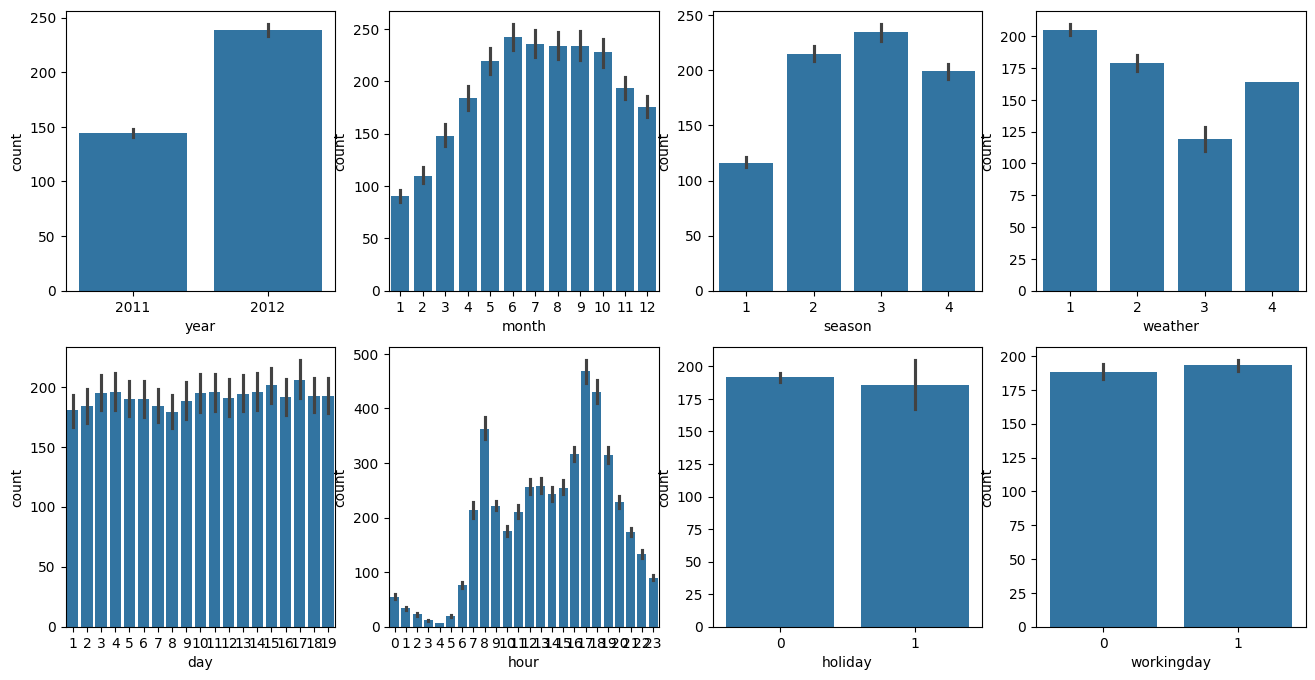

In [14]:
fig,axs = plt.subplots(figsize=(16, 8),ncols=4, nrows=2)
cat_features=['year', 'month', 'season', 'weather','day', 'hour','holiday','workingday']
#cat_features에 있는 모든 칼럼멸로 개별 칼럼값에 따른 count 의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    sns.barplot(x=feature,y='count', data=bike_df, ax=axs[row][col])

In [16]:
#다음과 같은 rmsle 구현은 오버플로나 언더플로 오류를 발생하기 쉬움
from sklearn.metrics import mean_squared_log_error
def rmsle(y,pred):
  msle = mean_squared_log_error(y,pred)
  rmsle = np.sqrt(mse)
  return rmsle

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#log 감소 변환 시 Nan 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y, pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred) ** 2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

#사이킷런의 mean_square_error를 이용해 rmse 계산
def rmse(y,pred):
  return np.sqrt(mean_squared_error(y,pred))

#mae, rmse, rmsle를 모두 계산
def evaluate_regr(y, pred):
  rmsle_val=rmsle(y,pred)
  rmse_val=rmse(y,pred)
  mae_val=mean_absolute_error(y,pred)

  print('RMSLE : {0:.3f}, RMSE : {1:.3F}, MAE : {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

## 로그 변환, 피처 인코딩과 모델 학습/예측/평가

In [27]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count', 'datetime', 'casual', 'registered'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
pred=lr_reg.predict(X_test)
evaluate_regr(y_test, pred)

RMSLE : 1.165, RMSE : 140.900, MAE : 105.924


In [28]:
def get_top_error_date(y_test, pred, n_tops=5):
  #dataframe의 칼럼으로 실제 대여 횟수 count와 예측값을 서로 비교할 수 있도록 생성
  result_df = pd.DataFrame(y_test.values, columns=['real_count'])
  result_df['predicted_count'] = np.round(pred)
  result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

  #예측값과 실제 값이 가장 큰 데이터 순으로 출력
  print(result_df.sort_values('diff', ascending=False)[:n_tops])
get_top_error_date(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
966          884            327.0  557.0
3151         798            241.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<Axes: >

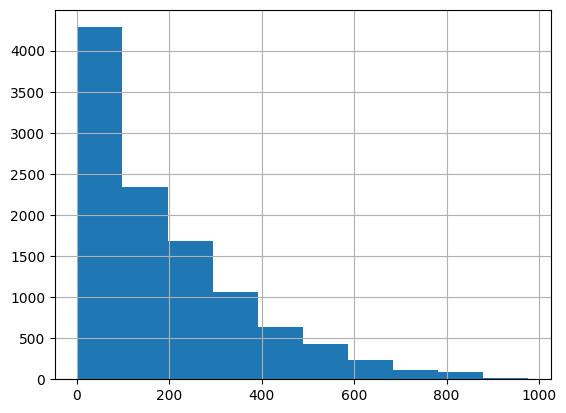

In [29]:
y_target.hist()

<Axes: >

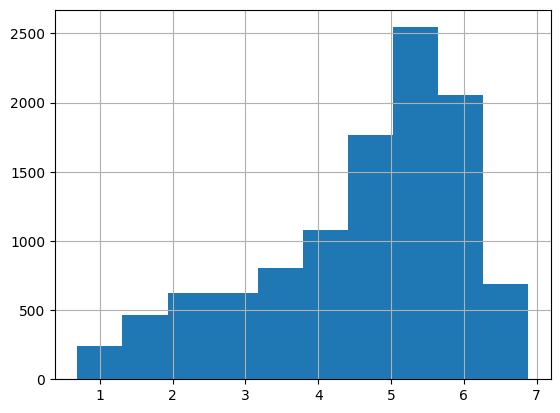

In [30]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [31]:
#타깃 칼럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
pred=lr_reg.predict(X_test)
y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)
evaluate_regr(y_test_exp, pred_exp)

RMSLE : 1.017, RMSE : 162.594, MAE : 109.286


<Axes: ylabel='None'>

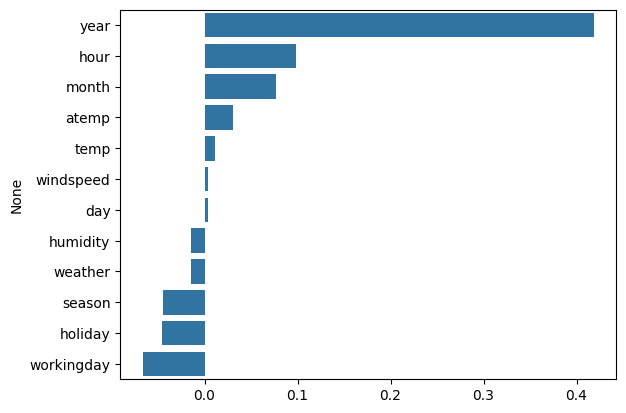

In [32]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [33]:
#year, month, day, hour 등의 피처들을 one hot encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather'])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  if is_expm1:
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
  print('###', model.__class__.__name__, '###')
  evaluate_regr(y_test, pred)

lr_reg=LinearRegression()
ridge_reg=Ridge(alpha=10)
lasso_reg=Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
  get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE : 0.590, RMSE : 97.688, MAE : 63.382
### Ridge ###
RMSLE : 0.590, RMSE : 98.529, MAE : 63.893
### Lasso ###
RMSLE : 0.635, RMSE : 113.219, MAE : 72.803


<Axes: ylabel='None'>

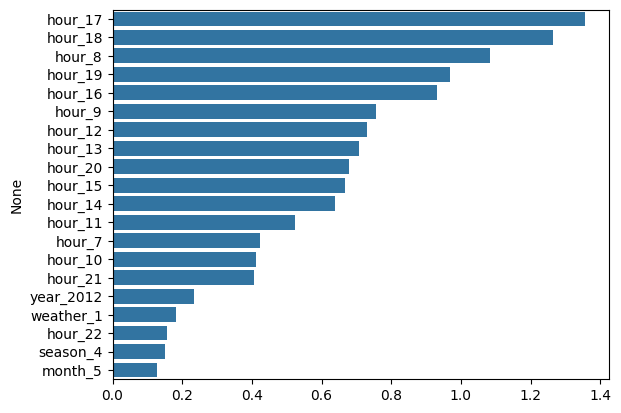

In [35]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [36]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
  get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

### RandomForestRegressor ###
RMSLE : 0.355, RMSE : 50.510, MAE : 31.250
### GradientBoostingRegressor ###
RMSLE : 0.330, RMSE : 53.326, MAE : 32.732
### XGBRegressor ###
RMSLE : 0.339, RMSE : 51.475, MAE : 31.357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043
### LGBMRegressor ###
RMSLE : 0.319, RMSE : 47.215, MAE : 29.029


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


# 10. 회귀 실습 - 캐글 주택 가격 : 고급 회귀 기법

In [37]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('house_price.csv')
house_df=house_df_org.copy()

house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [38]:
print('데이터 세트의 shape :', house_df.shape)
print('\n전체 피처의 type \n', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 칼럼과 그 건수 \n', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 shape : (1460, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 칼럼과 그 건수 
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


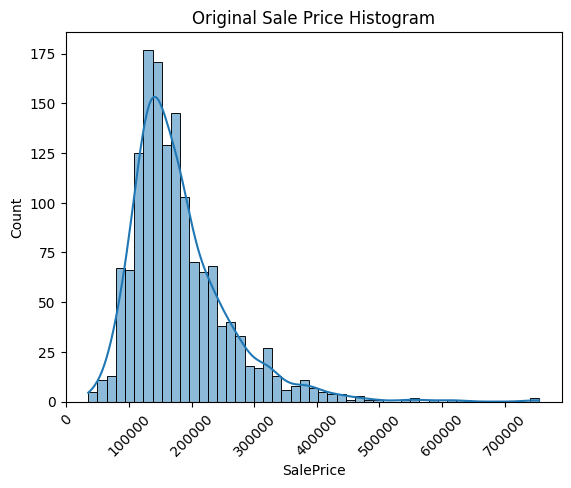

In [41]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=45)
sns.histplot(house_df['SalePrice'], kde=True)
plt.show()

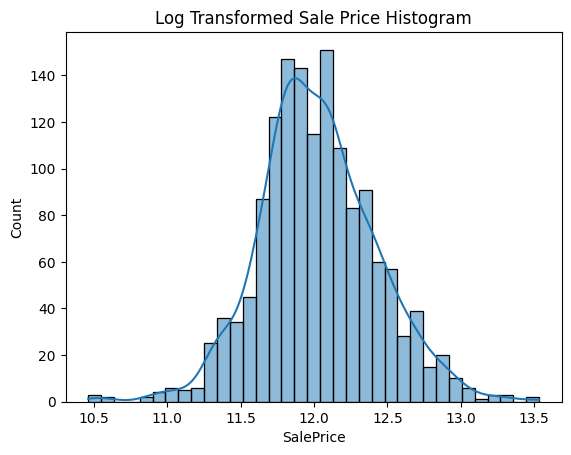

In [42]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

In [51]:
#SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

#null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id', 'PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1, inplace=True)
#이미 실행돼 삭제 후 다시 실행돼 오류 메시지 뜸

KeyError: "['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'] not found in axis"

In [52]:
#드롭하지 않는 숫자형 null 칼럼은 평균값으로 대체
house_df.fillna(house_df.mean(numeric_only=True), inplace=True)
#null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type : \n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type : 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [53]:
print('get_dummies() 수행 전 데이터 shape :', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 shape :', house_df_ohe.shape)

null_column_count=house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type : \n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 shape : (1460, 75)
get_dummies() 수행 후 데이터 shape : (1460, 270)
## Null 피처의 Type : 
 Series([], dtype: object)


## 선형 회귀 모델 학습/예측/평가

In [54]:
def get_rmse(model):
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test, pred)
  rmse = np.sqrt(mse)
  print(model.__class__.__name__, '로그 변환된 RMSE :', np.round(rmse,3))
  return rmse
def get_rmses(models):
  rmses = []
  for model in models:
    rmse = get_rmse(model)
    rmses.append(rmse)
  return rmses

In [55]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop(['SalePrice'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
ridge_reg= Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE : 0.0
Ridge 로그 변환된 RMSE : 0.0
Lasso 로그 변환된 RMSE : 0.001


[np.float64(0.00022333431024302908),
 np.float64(0.00021077653877911475),
 np.float64(0.0006405475774311254)]

In [56]:
def get_top_bottom_coef(model, n=10):
  coef = pd.Series(model.coef_, index=X_features.columns)
  coef_high = coef.sort_values(ascending=False).head(n)
  coef_low = coef.sort_values(ascending=False).tail(n)
  return coef_high, coef_low

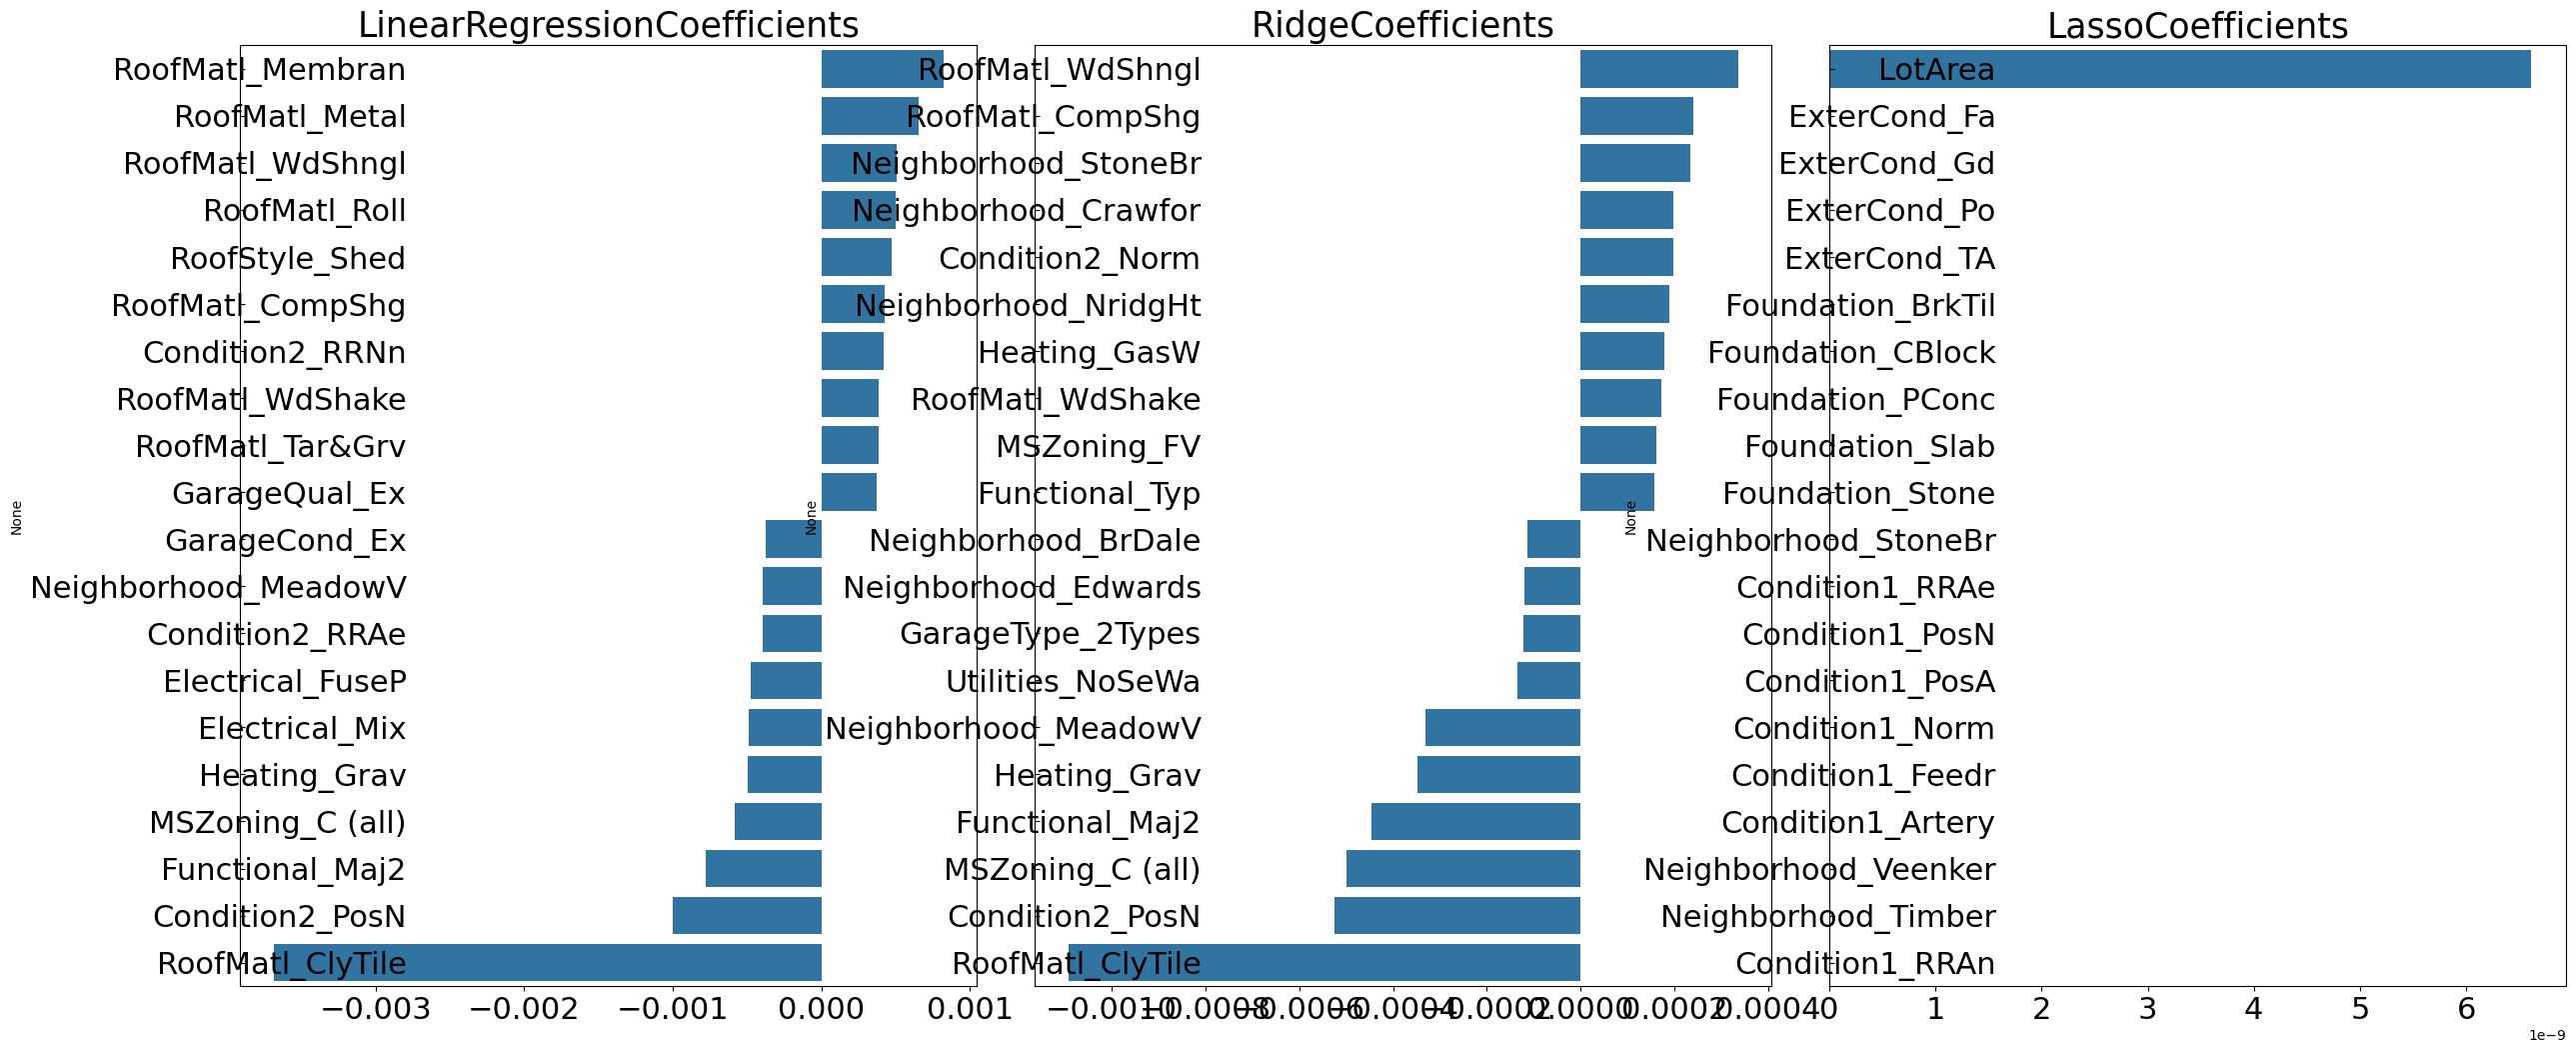

In [58]:
def visualize_coefficient(models):
  fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
  fig.tight_layout()

  for i_num, model in enumerate(models):
    coef_high, coef_low = get_top_bottom_coef(model)
    coef_concat = pd.concat([coef_high, coef_low])

    axs[i_num].set_title(model.__class__.__name__+'Coefficients', size=25)
    axs[i_num].tick_params(axis="y", direction='in', pad=-120)
    for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
      label.set_fontsize(22)
    sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [59]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
  for model in models:
    rmse_list=np.sqrt(-cross_val_score(model, X_features, y_target, scoring='neg_mean_squared_error', cv=5))
    rmse_avg = np.mean(rmse_list)
    print('\m{0} CV RMSE 값 리스트 : {1}'.format(model.__class__.__name__, np.round(rmse_list,3)))
    print('{0} CV 평균 RMSE 값 : {1}'.format(model.__class__.__name__, np.round(rmse_avg,3)))

models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)

\mLinearRegression CV RMSE 값 리스트 : [0. 0. 0. 0. 0.]
LinearRegression CV 평균 RMSE 값 : 0.0
\mRidge CV RMSE 값 리스트 : [0. 0. 0. 0. 0.]
Ridge CV 평균 RMSE 값 : 0.0
\mLasso CV RMSE 값 리스트 : [0.001 0.001 0.001 0.001 0.001]
Lasso CV 평균 RMSE 값 : 0.001


In [60]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
  grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
  grid_model.fit(X_features, y_target)
  rmse = np.sqrt(-1*grid_model.best_score_)
  print('{0} 5 CV 시 최적 평균 RMSE 값 : {1}, 최적 alpha : {2}'.format(model.__class__.__name__, np.round(rmse,4), grid_model.best_params_))

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.0002, 최적 alpha : {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.0003, 최적 alpha : {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE : 0.0
Ridge 로그 변환된 RMSE : 0.0
Lasso 로그 변환된 RMSE : 0.0


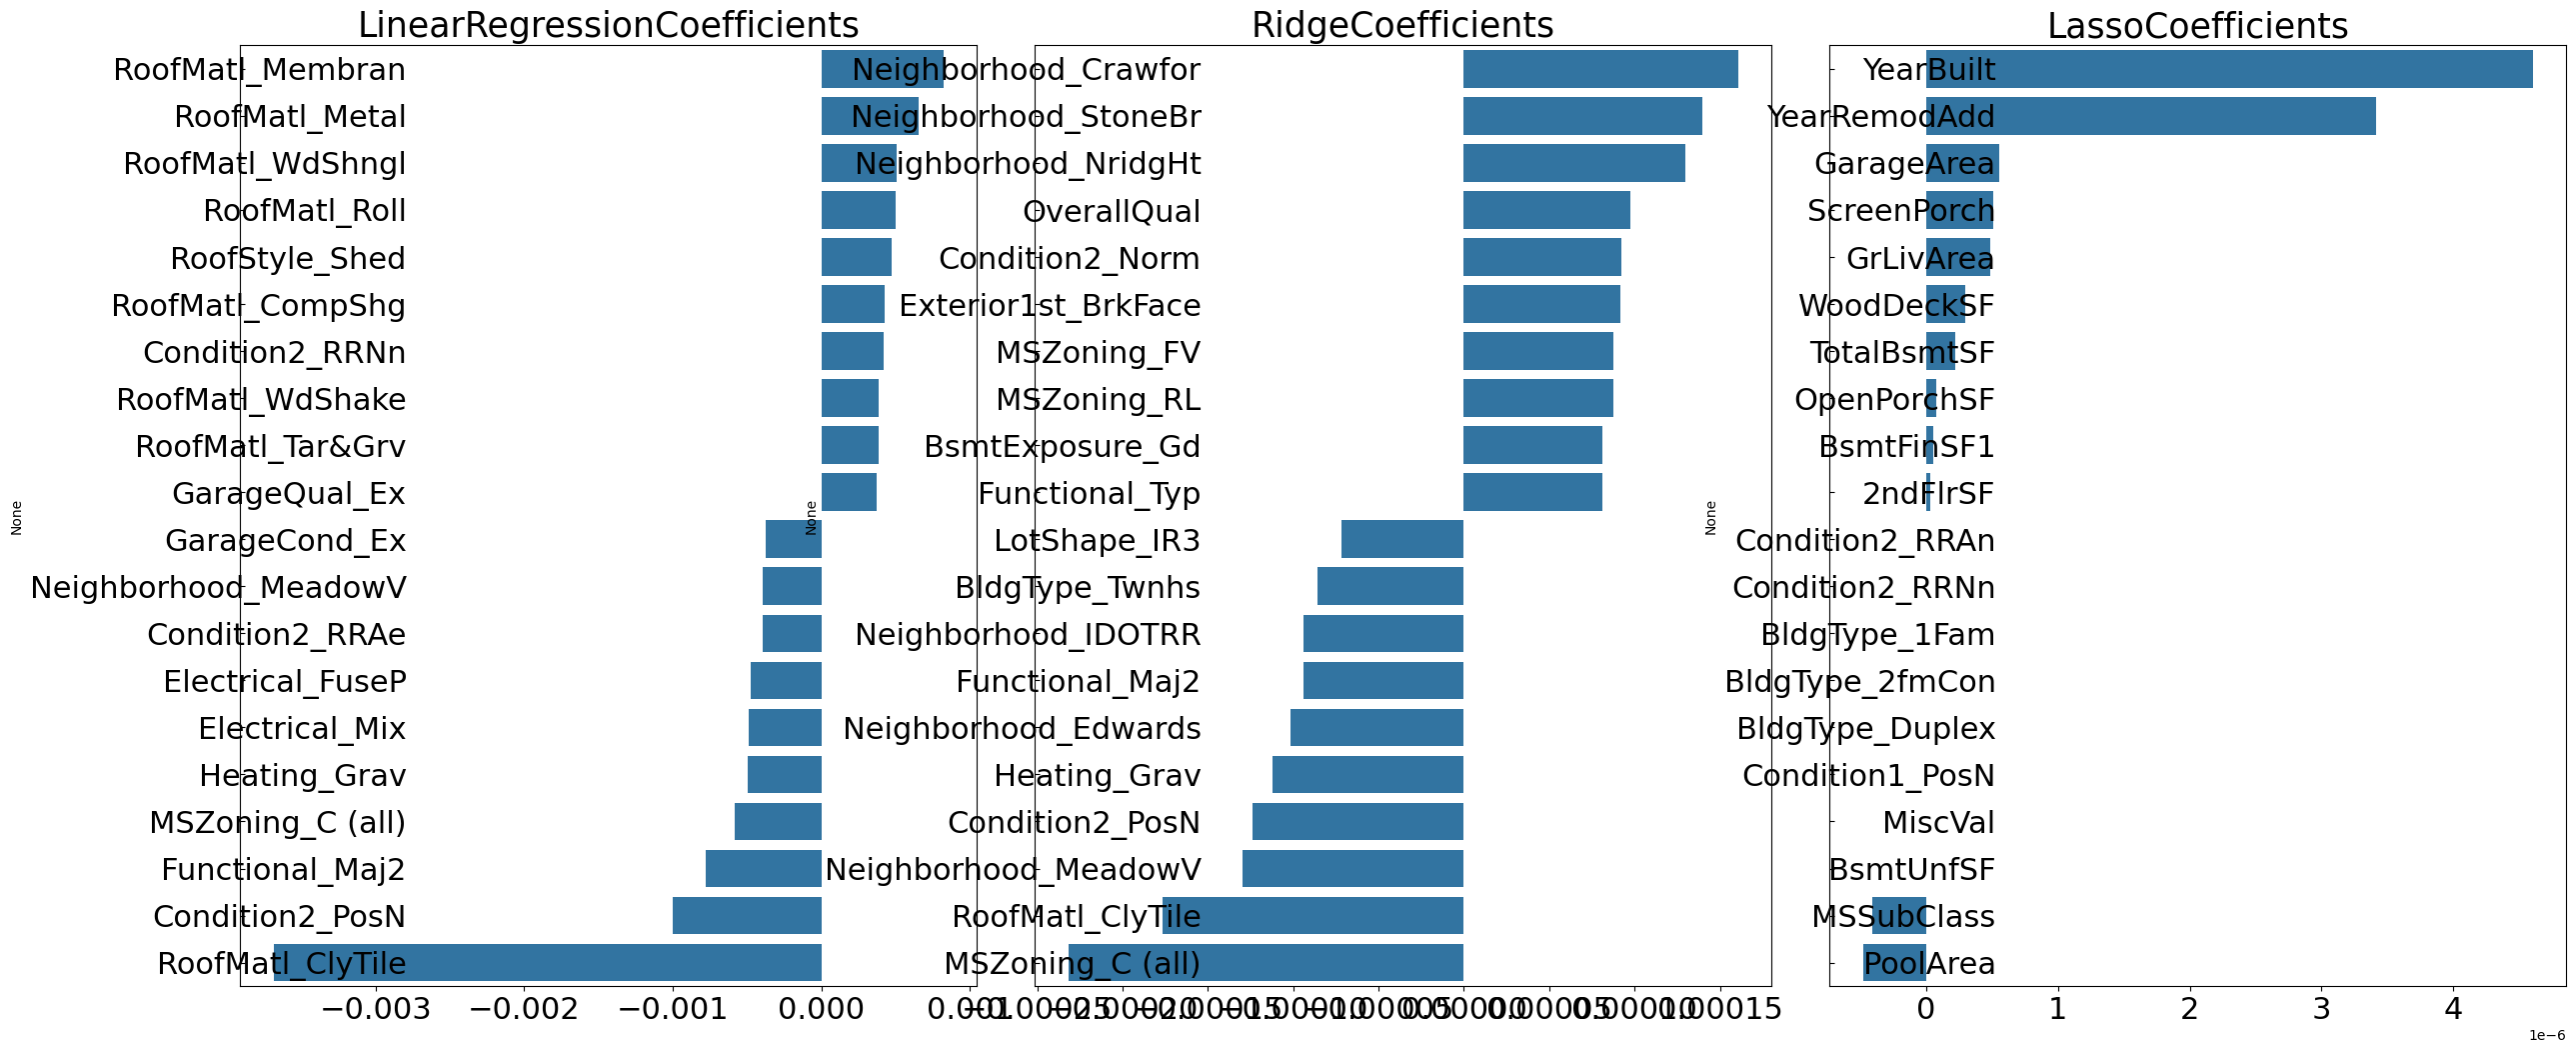

In [61]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10) #교재와 다르지만 노트북 내 결과인 10 사용하겠음
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [62]:
from scipy.stats import skew
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
skew_features = house_df[features_index].apply(lambda x : skew(x))
skew_features_top = skew_features[skew_features >1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [63]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [65]:
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop(['SalePrice'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params={'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params={'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.0002, 최적 alpha : {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.0004, 최적 alpha : {'alpha': 0.001}


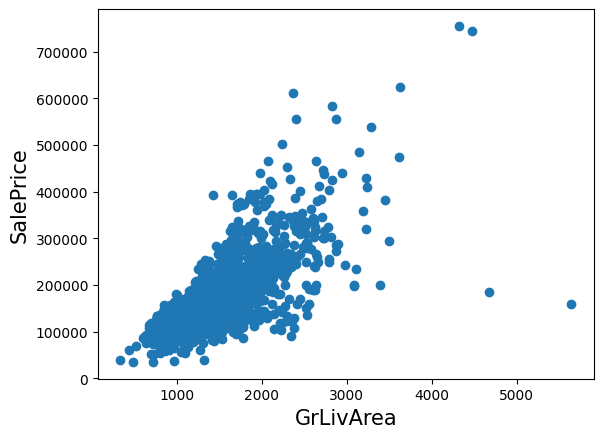

In [66]:
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.xlabel('GrLivArea', fontsize=15)
plt.ylabel('SalePrice', fontsize=15)
plt.show()

In [69]:
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index:', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape:', house_df_ohe.shape)
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

이상치 레코드 index: []
이상치 삭제 전 house_df_ohe shape: (1456, 270)
이상치 삭제 후 house_df_ohe shape: (1456, 270)


In [70]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop(['SalePrice'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params={'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params={'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.0002, 최적 alpha : {'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.0004, 최적 alpha : {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE : 0.0
Ridge 로그 변환된 RMSE : 0.0
Lasso 로그 변환된 RMSE : 0.0


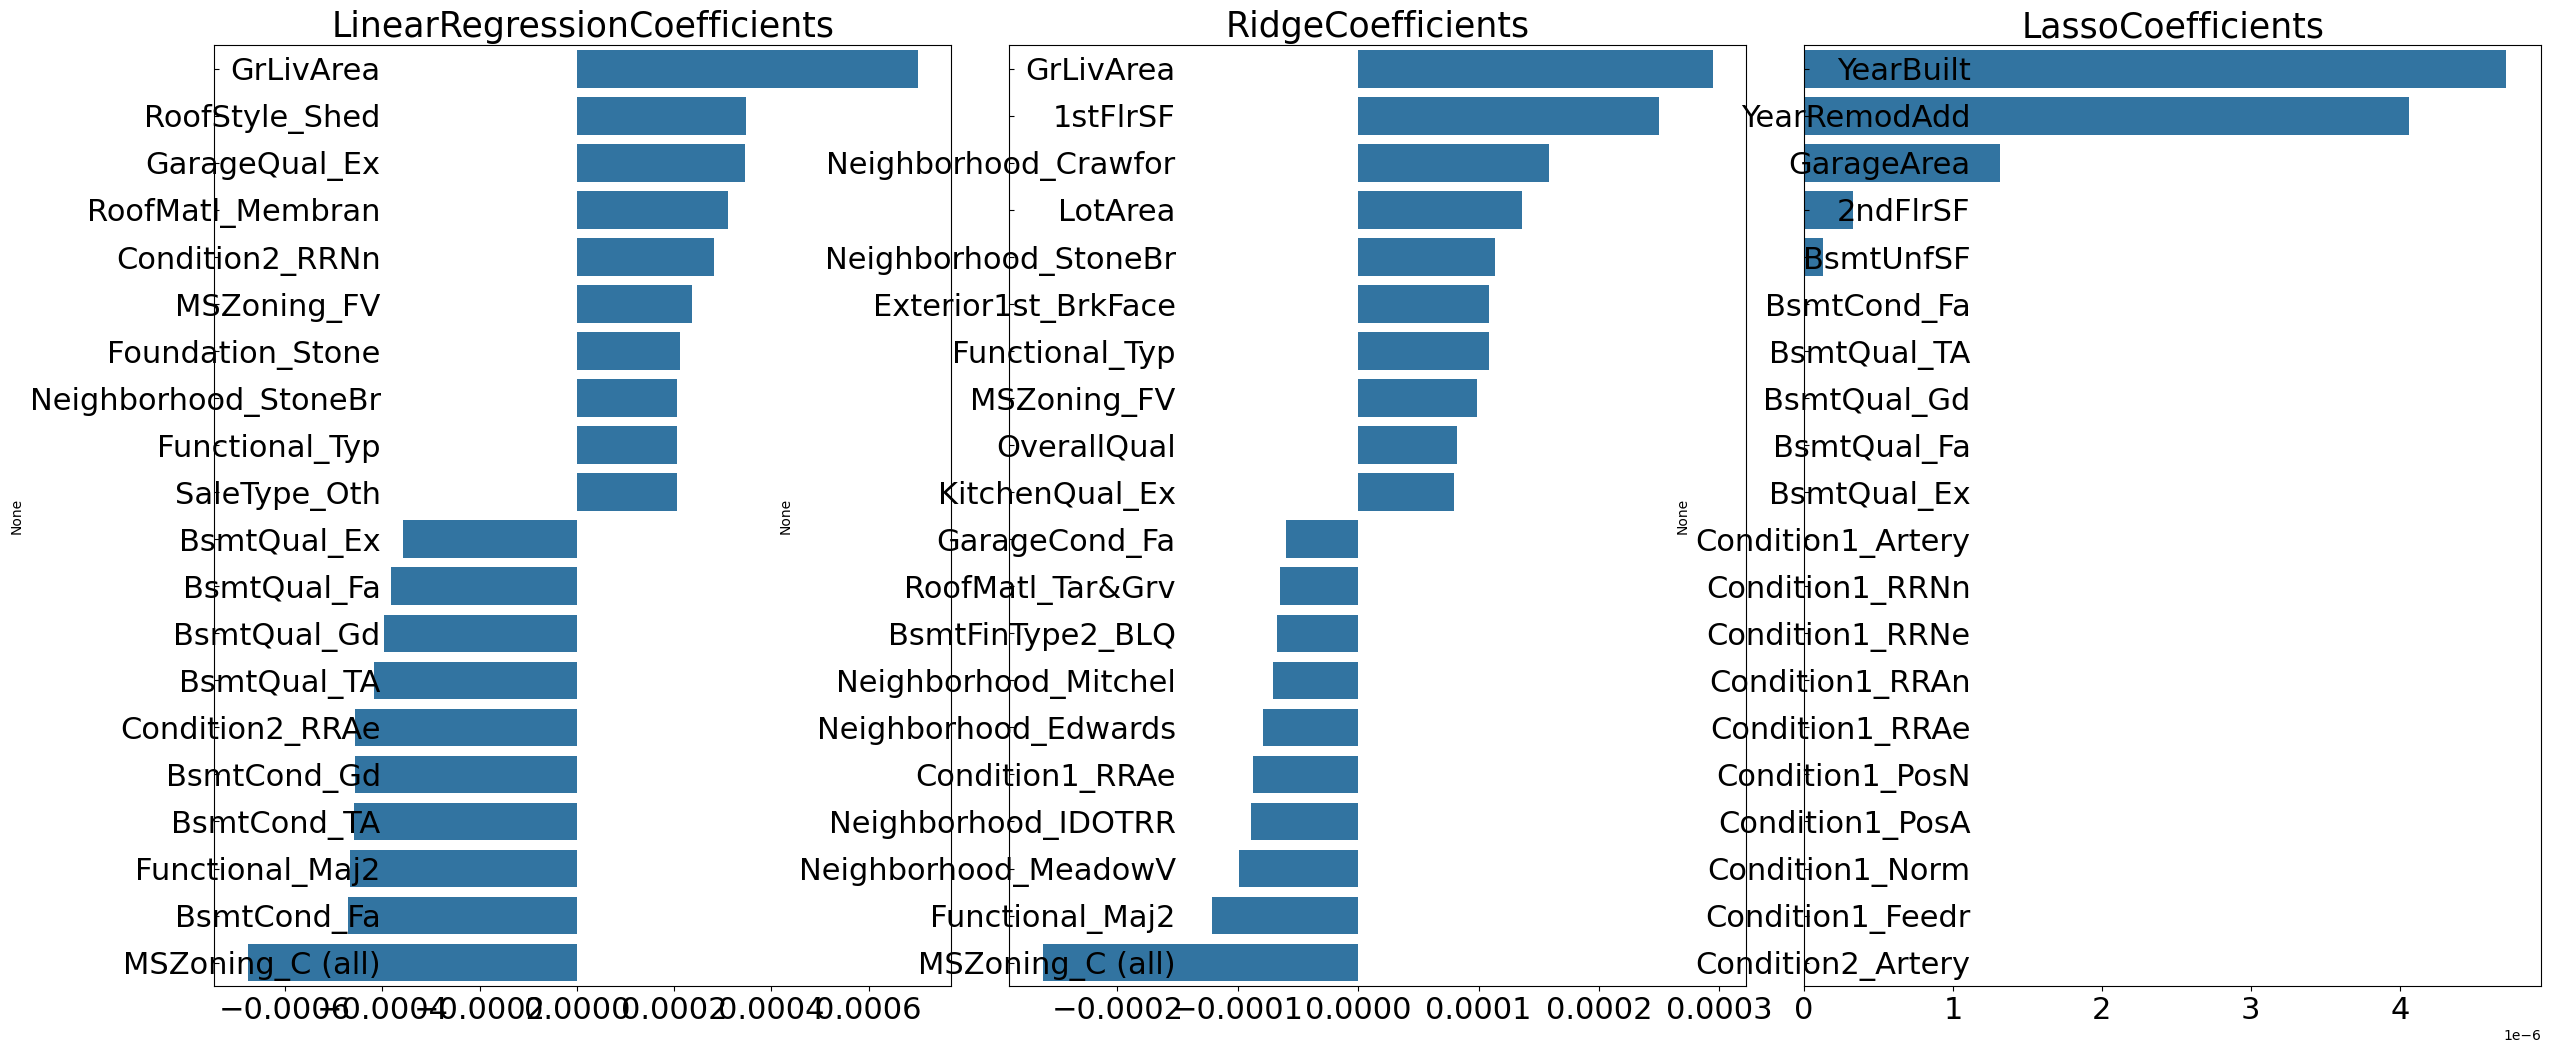

In [71]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

## 회귀 트리 모델 학습/예측/평가

In [72]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값 : 0.0002, 최적 alpha : {'n_estimators': 1000}


In [73]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3148
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 170
[LightGBM] [Info] Start training from score 0.325597
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3166
[LightGBM] [Info] Number of data points in the train set: 1165, number of used features: 168
[LightGBM] [Info] Start training from score 0.325601
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [

## 회귀 모델의 예측 결과 혼합을 통한 최종 예측

In [74]:
def get_rmse_pred(preds):
  for key in preds.keys():
    pred_value = preds[key]
    mse = mean_squared_error(y_test, pred_value)
    rmse = np.sqrt(mse)
    print('{0} RMSE : {1}'.format(key, rmse))

#개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

#개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

#개별 모델의 예측값 혼합으로 최종 예측값 도출
pred = 0.4*ridge_pred + 0.6*lasso_pred
preds = {'최종 혼합':pred,'Ridge':ridge_pred, 'Lasso':lasso_pred, 'Ridge+Lasso':pred}
get_rmse_pred(preds)

최종 혼합 RMSE : 0.0002963037111543586
Ridge RMSE : 0.00019849459551282822
Lasso RMSE : 0.00040752471935116927
Ridge+Lasso RMSE : 0.0002963037111543586


In [75]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)
pred = 0.5*xgb_pred + 0.5*lgbm_pred

preds = {'최종 혼합':pred,'XGBoost':xgb_pred, 'LightGBM':lgbm_pred, 'XGB+LightGBM':pred}
get_rmse_pred(preds)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3164
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 169
[LightGBM] [Info] Start training from score 0.325614
최종 혼합 RMSE : 0.00020499224632277878
XGBoost RMSE : 0.00022693736418076435
LightGBM RMSE : 0.00019931043876006782
XGB+LightGBM RMSE : 0.00020499224632277878


## 스태킹 앙상블 모델을 통한 회귀 예측

In [76]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(models, X_train_n, y_train_n, X_test_n, n_folds):
  kf = KFold(n_splits=n_folds, shuffle=False)
  train_fold_pred = np.zeros((X_train_n.shape[0],1))
  test_pred = np.zeros((X_test_n.shape[0], n_folds))

  print(model.__class__.__name__, 'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    print('\t 폴드 세트 : ', folder_counter, '시작')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    model.fit(X_tr, y_tr)
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
    test_pred[:, folder_counter] = model.predict(X_test_n)

  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
  return train_fold_pred, test_pred_mean

In [77]:
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

LGBMRegressor model 시작
	 폴드 세트 :  0 시작
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2968
[LightGBM] [Info] Number of data points in the train set: 931, number of used features: 157
[LightGBM] [Info] Start training from score 0.325618
	 폴드 세트 :  1 시작
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2936
[LightGBM] [Info] Number of data points in the train set: 931, number of used features: 160
[LightGBM] [Info] Start training from score 0.325604
	 폴드 세트 :  2 시작
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002227 seconds.
You can set `fo

In [78]:
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

meta_model_lasso_reg = Lasso(alpha=0.0005)

meta_model_lasso_reg.fit(Stack_final_X_train, y_train)
final = meta_model_lasso_reg.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은 : ',rmse)

스태킹 회귀 모델의 최종 RMSE 값은 :  0.000673757299037238
